# Import changes (N2) :

In [293]:
import pandas as pd
import numpy as np
import csv
import re
from collections import Counter
import seaborn as sns

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv("data/export_n2.csv", encoding ='ISO-8859-1')

### Drop unecesary columns

In [295]:
df.columns

Index(['type', 'activity', 'sex_', 'injury', 'fatal_(y/n)', 'species_',
       'shark_specie', 'activity_group', 'severity_group', 'body_group'],
      dtype='object')

In [296]:
df.drop("activity", axis=1, inplace=True)
df.drop("injury", axis=1, inplace=True)
df.drop("species_", axis=1, inplace=True)

In [298]:
df.columns

Index(['type', 'sex_', 'fatal_(y/n)', 'shark_specie', 'activity_group',
       'severity_group', 'body_group'],
      dtype='object')

In [299]:
df.columns = ["type", "sex", "fatal", "specie","activity", "injuries","body_area"]

In [300]:
df = df[["sex", "activity", "type","specie","injuries", "body_area","fatal" ]]

# Visualization

In [301]:
# Matplotlib inline to visualize Matplotlib graphs
%matplotlib inline
%config Inlinebackend.figure_format= 'retina'

In [302]:
# Configuration to set so that all the Seaborn figs come out with this size
sns.set_context("poster")
sns.set(rc={"figure.figsize": (12.,6.)})
sns.set_style("whitegrid")

# PLOTS 

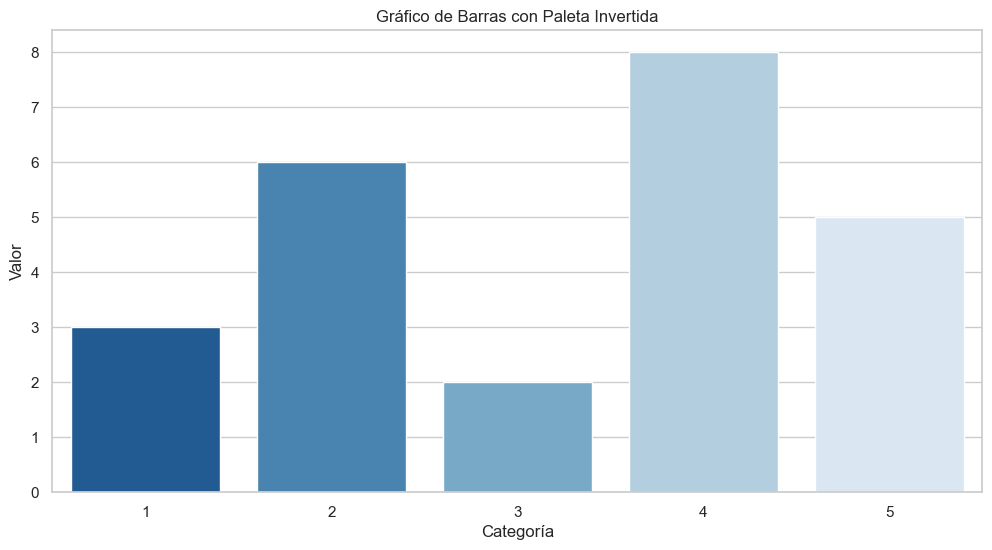

In [308]:
# Ejemplo de paleta Blues de Seaborn
original_palette = sns.color_palette("Blues", n_colors=5)

# Invierte los colores de la paleta
inverted_palette = list(reversed(original_palette))

# Crea un gráfico de barras usando la paleta invertida
sns.barplot(x=[1, 2, 3, 4, 5], y=[3, 6, 2, 8, 5], palette=inverted_palette)

plt.xlabel('Categoría')
plt.ylabel('Valor')
plt.title('Gráfico de Barras con Paleta Invertida')
plt.show()


### 1. Count of attacks based on fatality

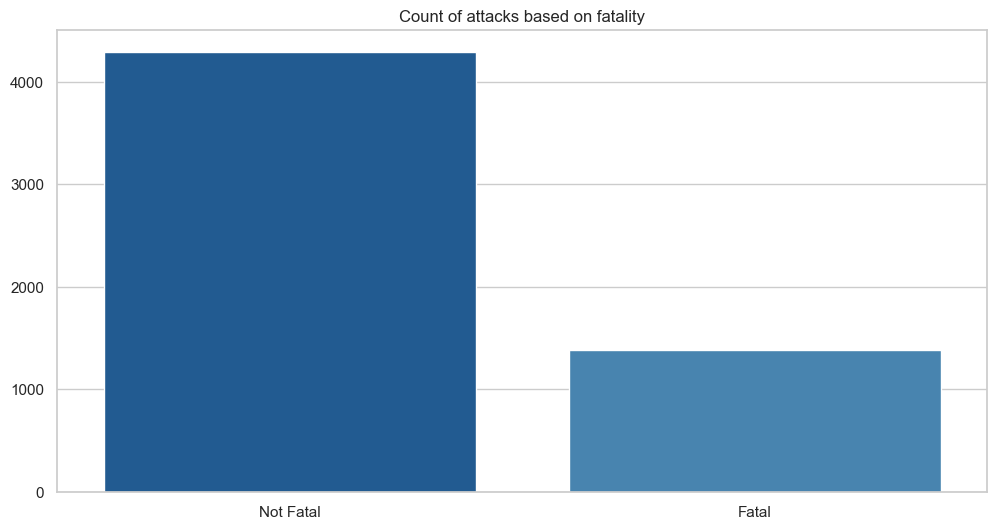

In [352]:
sns.countplot(x=df.fatal, palette = inverted_palette );
plt.xticks(ticks=[0, 1], labels=['Not Fatal', 'Fatal'])
plt.xlabel('')
plt.ylabel('')
plt.title('Count of attacks based on fatality')
plt.savefig('images/shark_attacks_fatality.png')
plt.show()

### 2. Count of attacks based on injuries

In [338]:
df['injuries'].value_counts()

injuries
Amputations or Lacerations    3164
Undetermined                  2140
Minor or No injuries           962
Name: count, dtype: int64

In [339]:
injur_expected = ["Amputations or Lacerations", "Minor or No injuries"]

In [340]:
df_injur_expected = df[df["injuries"].isin(injur_expected)]

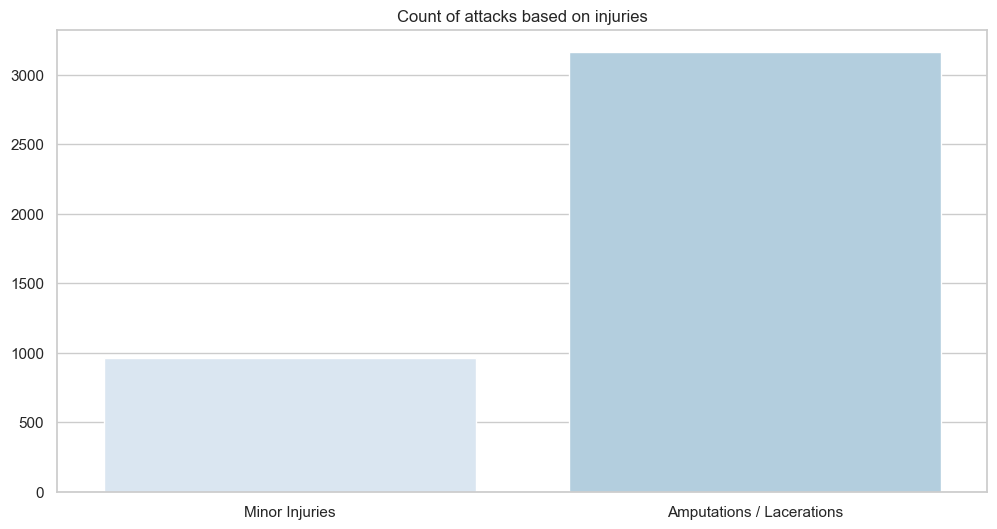

In [357]:
sns.countplot(x=df_injur_expected.injuries, palette = original_palette);
plt.xticks(ticks=[0, 1], labels=['Minor Injuries', 'Amputations / Lacerations'])
plt.xlabel('')
plt.ylabel('')
plt.title('Count of attacks based on injuries')
plt.savefig('images/shark_attacks_injuries.png')
plt.show()

### 3. Count of attacks based on body parts injured:

In [342]:
df['body_area'].value_counts()

body_area
Undetermined         2908
Lower extremities    2274
Upper extremities     942
Torso                 142
Name: count, dtype: int64

In [343]:
body_areas = df['body_area'].value_counts().index.tolist()

In [344]:
body_areas.remove("Undetermined")

In [345]:
df_body_areas = df[df["body_area"].isin(body_areas)]

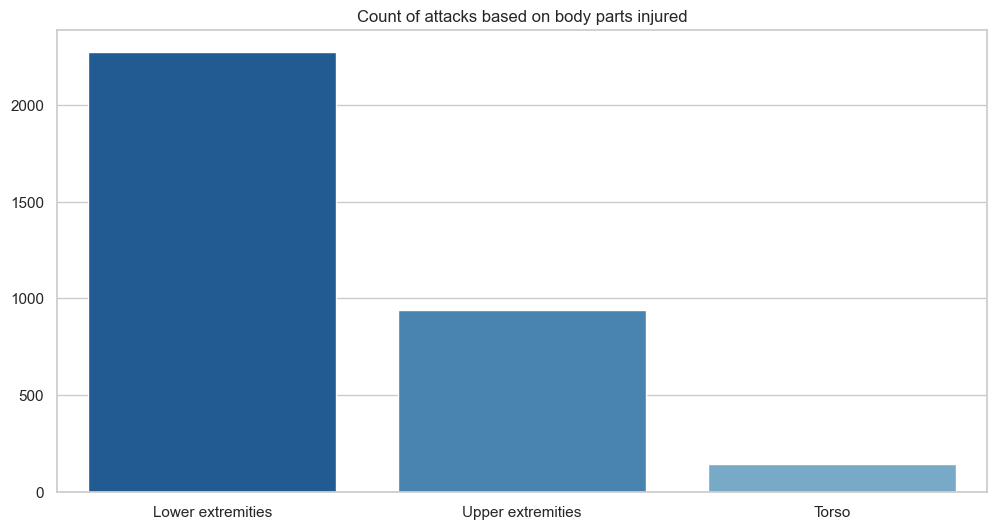

In [347]:
#sns.countplot(x=df_body_areas.body_area);
sns.countplot(x = df_body_areas["body_area"], palette=inverted_palette);
plt.xlabel('')
plt.ylabel('')
plt.title('Count of attacks based on body parts injured')
plt.savefig('images/shark_attacks_body_parts.png')
plt.show()

### 4. Count of attacks based on shark species:

In [139]:
# 1. We create a list with Top5 species:
top5_specie = df["specie"].value_counts().head(6).index.tolist()

# 2. As we don't want "Unidentify" to be in the list and we know
#   is in top 5 values, we do top6 and remove "Unidentify"
top5_specie.remove("Unidentify")

# 2. We create a subset whith species values thar are in the list:
df_specie_top5 = df[df["specie"].isin(top5_specie)]

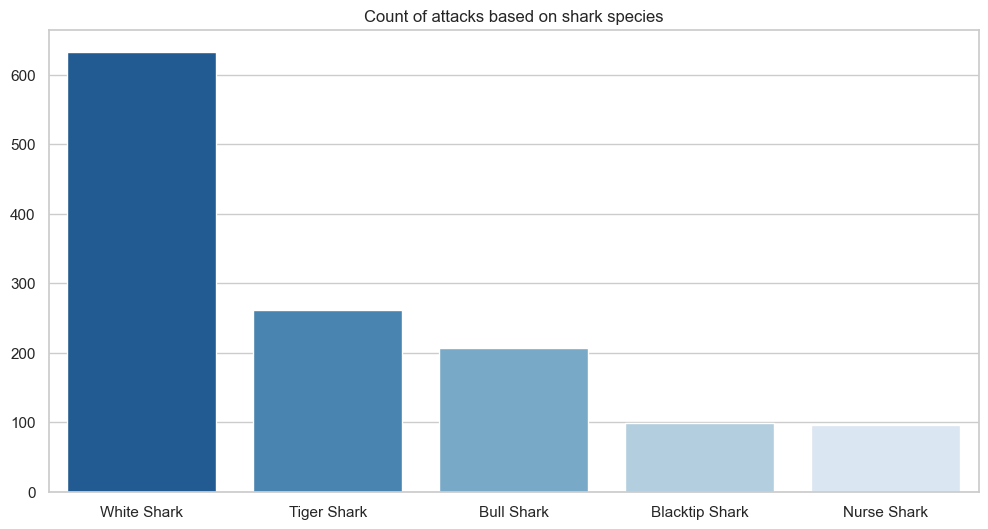

In [355]:
sns.countplot(x=df_specie_top5.specie, palette=inverted_palette, order=df_specie_top5['specie'].value_counts().index);
plt.xlabel('')
plt.ylabel('')
plt.title('Count of attacks based on shark species')
plt.savefig('images/shark_attacks_shark_species.png')
plt.show()

## 5. Avoiding Ranking

### Attack points

In [ ]:
#Puntos del 1 al 10, mas probabilidades de un ataque severo 

#% de que el ataque impliue una amputacion --> puntos 

#En los ataques registrados de este 

In [174]:
# For this analysis just top5 species:

df_specie_top5

# 2. We are just going to analyze columns: specie/injuries
df_species = df_specie_top5[["specie", "injuries","activity", "fatal"]]

In [175]:
df_attack = pd.DataFrame(df_species.groupby(["specie", "injuries"])["injuries"].count())
df_attack.rename(columns={'injuries': 'counts'}, inplace=True)

In [176]:
total_injuries = df_attack.groupby('specie')['counts'].sum()

In [177]:
df_attack['attack_points'] = df_attack['counts'] / total_injuries[df_attack.index.get_level_values('specie')].values * 10

In [178]:
df_attack

counts  attack_points
specie         injuries                                         
Blacktip Shark Amputations or Lacerations      76       7.676768
               Minor or No injuries             9       0.909091
               Undetermined                    14       1.414141
Bull Shark     Amputations or Lacerations     144       6.956522
               Minor or No injuries            10       0.483092
               Undetermined                    53       2.560386
Nurse Shark    Amputations or Lacerations      52       5.416667
               Minor or No injuries            17       1.770833
               Undetermined                    27       2.812500
Tiger Shark    Amputations or Lacerations     141       5.402299
               Minor or No injuries            44       1.685824
               Undetermined                    76       2.911877
White Shark    Amputations or Lacerations     260       4.107425
               Minor or No injuries           218       3.443918
               Undetermined                   155       2.448657

In [205]:
dict_specie_points = {}

for specie, injury in df_attack.index:
    
    cat = "Amputations or Lacerations"
    
    #select a specific combination of levels
    subset = df_attack.loc[(specie, cat)]
    
    points = int(round(subset.attack_points))
    
    dict_specie_points[specie] = points
    
dict_specie_points 

{'Blacktip Shark': 8,
 'Bull Shark': 7,
 'Nurse Shark': 5,
 'Tiger Shark': 5,
 'White Shark': 4}

### Fatality 

In [181]:
df_fatal = pd.DataFrame(df_species.groupby(["specie", "fatal"])["fatal"].count())

df_fatal.rename(columns={'fatal': 'f_counts'}, inplace=True)

In [183]:
total_fatal = df_fatal.groupby('specie')['f_counts'].sum()

In [185]:
df_fatal['fatality'] = df_fatal['f_counts'] / total_fatal[df_fatal.index.get_level_values('specie')].values * 100

In [186]:
df_fatal

f_counts    fatality
specie         fatal                      
Blacktip Shark N            99  100.000000
Bull Shark     N           162   78.640777
               Y            44   21.359223
Nurse Shark    N            94   98.947368
               Y             1    1.052632
Tiger Shark    N           185   71.984436
               Y            72   28.015564
White Shark    N           478   77.221325
               Y           141   22.778675

In [219]:
dict_fatality = {}

for specie, fatal in df_fatal.index:
    
    fatal = "N"
    
    #select a specific combination of levels
    sub = df_fatal.loc[(specie, fatal)]
    
    points = 100 - int(round(sub.fatality))
    
    dict_fatality[specie] = points
    
dict_fatality

{'Blacktip Shark': 0,
 'Bull Shark': 21,
 'Nurse Shark': 1,
 'Tiger Shark': 28,
 'White Shark': 23}

In [227]:
df_resume = pd.DataFrame([dict_fatality, dict_specie_points]).T
df_resume.columns = ["%_fatality", "attack_points"]

df_resume["avoid"] = (df_resume["attack_points"]*0.3)+(df_resume["%_fatality"]*0.07)
df_resume.sort_values(by="avoid", ascending=False)

,%_fatality,attack_points,avoid
Bull Shark,21,7,3.57
Tiger Shark,28,5,3.46
White Shark,23,4,2.81
Blacktip Shark,0,8,2.40
Nurse Shark,1,5,1.57


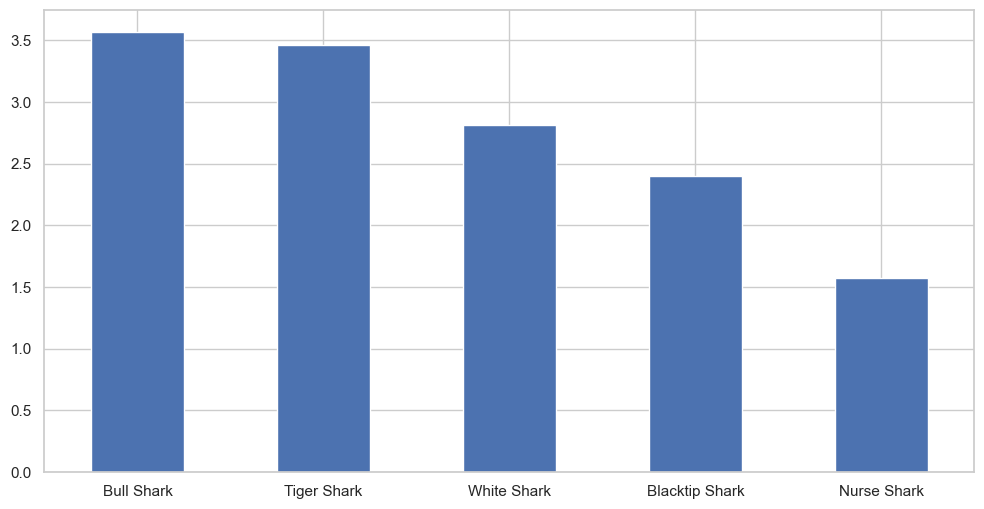

In [254]:
df_resume.avoid.sort_values(ascending=False).plot(kind="bar")
plt.xticks(rotation=0);

In [ ]:
df_decades = pd.DataFrame(df.groupby(["Decade"])["Decade"].count())
df_decades.rename(columns={'Decade': 'Count'}, inplace=True)
df_decades.sort_values(by="Count")
df_decades

